### Annotated phylogenetic tree using baltic

Load libraries

In [27]:
import baltic as bt
import pandas as pd
import numpy as np
import bezier
import itertools
import re
import copy


import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Polygon


from io import StringIO as sio
from io import BytesIO as csio

from IPython.display import HTML
from Bio import Phylo
from scipy.special import binom

import seaborn as sns

In [49]:
tree_path = '/Users/nashwa/Desktop/git/hmpxv_dynamics/out/skyline/hmpxv_skyline.trees'
t = bt.loadNexus(tree_path, tip_regex='_([0-9\-]+)$')

In [193]:
typeface='sans'
mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate

In [195]:
t.treeStats()

# for k in t.Objects: ## iterate over a flat list of branches
#     print('branch unique id: %s branch height: %.2f decimal date: %s'%(k.index,k.height,k.absoluteTime))
    
#     if len(k.traits)>0: ## branch has comments
#         print('branch has annotations: %s'%(', '.join(['(key: %s value: %s)'%(key,k.traits[key]) for key in k.traits])))
    
#     if k.branchType=='node': ## if branch is internal
#         print('branch is internal, with %s children and is the ancestor to %s'%(len(k.children),', '.join(k.leaves)))
    
#     elif k.branchType=='leaf': ## otherwise if branch is external
#         print('branch is external, named %s in tree string'%(k.name))


Tree height: 0.636416
Tree length: 14.700693
strictly bifurcating tree
annotations present

Numbers of objects in tree: 469 (234 nodes and 235 leaves)



extract location from tip name, assign traits to each tip object

In [97]:
for k in t.Objects:
    if k.branchType=='leaf':
        if len(k.traits)<1:
            k.traits['location'] = re.split("\_",k.name)[-2]


In [190]:
countries = [] 
country_counts = {}

regions = []
region_counts = {}


for k in t.Objects:
    if k.branchType=='leaf':
        countries.append(k.traits['location'])
        if k.traits['location'] in country_counts :
            country_counts[k.traits['location']] +=1
        else:
            country_counts[k.traits['location']] = 1
            
        k.traits['region'] = next(value for key, value in region.items() if k.traits['location'] in key)
        regions.append(k.traits['region'])
        if k.traits['region'] in region_counts:
            region_counts[k.traits['region']] += 1
        else:
            region_counts[k.traits['region']] = 1

print(country_counts)
print(region_counts)

{'Germany': 29, 'Switzerland': 7, 'Austria': 10, 'USA': 30, 'UnitedKingdom': 28, 'Slovenia': 18, 'Canada': 15, 'Portugal': 25, 'France': 10, 'Italy': 6, 'Colombia': 13, 'Spain': 7, 'Slovakia': 10, 'Belgium': 14, 'Finland': 3, 'Netherlands': 3, 'Peru': 7}
{'Western Europe': 101, 'North America': 45, 'Central/Eastern Europe': 28, 'Southern Europe': 38, 'South America': 20, 'Northern Europe': 3}


group and color by region

In [183]:
  
region = {('Canada','USA'):'North America',
          ('Finland'):'Northern Europe',
          ('Austria','Germany','Switzerland','UnitedKingdom','France','Belgium','Netherlands'):'Western Europe', 
          ('Slovakia','Slovenia'):'Central/Eastern Europe',
          ('Italy','Portugal','Spain'):'Southern Europe',
          ('Colombia','Peru'):'South America'}

color_code = {'North America': '#e2514a',
              'South America': '#fca55d',
              'Southern Europe': '#fee999',
              'Northern Europe': '#edf8a3',
              'Central/Eastern Europe': '#a2d9a4',
              'Western Europe': '#47a0b3'}

draw tree

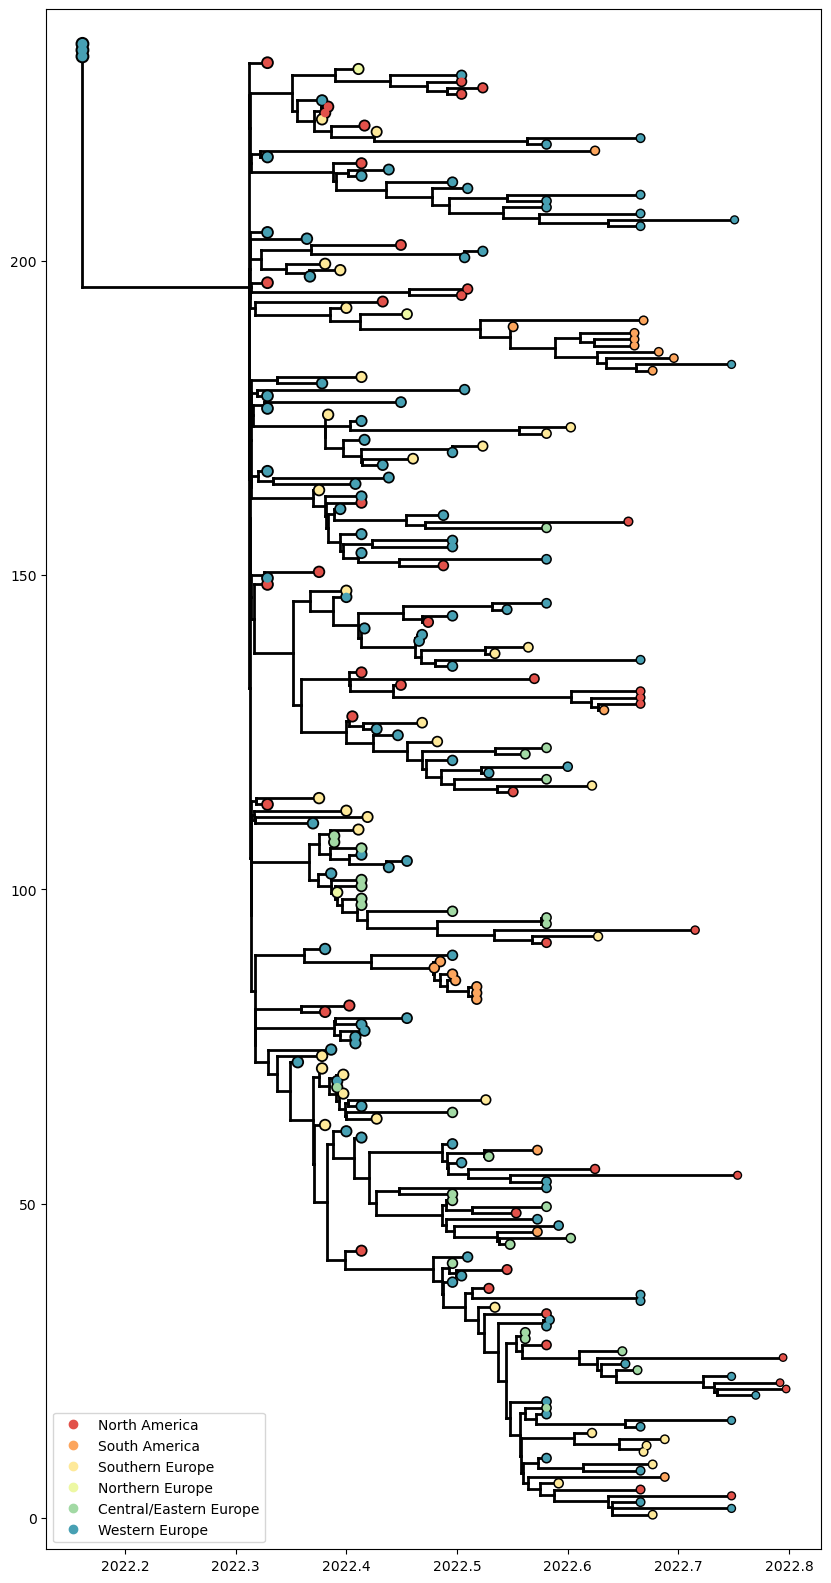

In [192]:
fig,ax = plt.subplots(figsize=(10,20),facecolor='w')

x_attr=lambda k: k.absoluteTime ## x coordinate of branches will be absoluteTime attribute
c_func=lambda k: color_code[k.traits['region']] if k.branchType=='leaf' else 'black'
s_func=lambda k: 50-30*k.height/t.treeHeight ## size of tips

t.plotTree(ax,x_attr=x_attr) ## plot branches
t.plotPoints(ax,x_attr=x_attr,size=s_func,colour=c_func,zorder=100) ## plot circles at tips

ax.set_ylim(-5,t.ySpan+5)
ax.ticklabel_format(useOffset=False)

markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in color_code.values()]
plt.legend(markers, color_code.keys(), numpoints=1)

plt.show()
